In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import talib
import os
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv, find_dotenv
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split

In [2]:
load_dotenv()

True

In [3]:
ticker = ["SPY"]
# Set timeframe to "1Day" for Alpaca API
timeframe = "1day"
# Format current date as ISO format
start_date = pd.Timestamp("2016-01-06", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2023-01-28", tz="America/New_York").isoformat()
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)


stock_data = api.get_bars(
    ticker,
    timeframe,
    start=start_date,
    end=end_date
).df

# Reorganize the DataFrame
# Separate ticker data
# Drop unwanted coloumns - Keep  Close
stock_data.drop(columns= ['trade_count','vwap','symbol'], inplace= True)
    # Combine individual stocks into a single data frame

  # Rename the coloumns to the ticker symbols in the list
#stock_data.columns = ticker
stock_data.index.name = 'Date'
stock_data.index_column = 'Date'
# Drop the N/As


# Drop the time component of the date
#df_ticker.index = df_ticker.index.date


# Display the data
display(stock_data)

,open,high,low,close,volume
Date,,,,,
2016-01-06 05:00:00+00:00,198.330,200.060,197.60,198.8200,152112604
2016-01-07 05:00:00+00:00,195.330,197.440,193.59,194.0500,213436023
2016-01-08 05:00:00+00:00,195.190,195.850,191.58,191.9230,209567228
2016-01-11 05:00:00+00:00,193.010,193.410,189.82,192.1100,187941153
2016-01-12 05:00:00+00:00,193.820,194.550,191.14,193.6608,172330490
...,...,...,...,...,...
2023-01-23 05:00:00+00:00,396.720,402.645,395.72,400.6300,84187957
2023-01-24 05:00:00+00:00,398.880,401.150,397.64,400.2000,59549719
2023-01-25 05:00:00+00:00,395.950,400.700,393.56,400.3500,84826825


In [4]:
# Calculate the 8 period moving average of the close
stock_data['8MA'] = stock_data['close'].ewm(8).mean()

# Calculate the 3 period moving average of the close
stock_data['3MA'] = stock_data['close'].ewm(3).mean()

# Calculate the 20 period moving average of the close
stock_data['20MA'] = stock_data['close'].ewm(20).mean()

# Calculate the difference between 3MA and 20MA
stock_data['Diff']=stock_data['3MA']-stock_data['20MA']

# Calculate the slope of 3MA, 2MA and 10MA
stock_data['8MASlope']=stock_data['8MA'].diff()
stock_data['3MASlope']=stock_data['3MA'].diff()
stock_data['20MASlope']=stock_data['20MA'].diff()

# Calculate the difference between close price and 3MA
stock_data['CloseDiff3MA']=stock_data['close']/stock_data['3MA']

# Calculate the percent change of the close price
stock_data['close']=stock_data['close'].pct_change()

# Initialize the signal column
stock_data["Signal"] = 0.0

In [5]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(stock_data[['8MA', '3MA', '20MA', 'Diff', '3MASlope', '8MASlope', '20MASlope', 'CloseDiff3MA']], stock_data["Signal"], test_size=0.2, random_state=0)

In [6]:
# Build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(16, input_dim=8, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [7]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
# Fit the model to the training data
model.fit(X_train, y_train, epochs=100, batch_size=32)


Epoch 1/100
45/45 [==============================] - 0s 809us/step - loss: nan - accuracy: 0.8629   
Epoch 2/100
45/45 [==============================] - 0s 749us/step - loss: nan - accuracy: 1.0000
Epoch 3/100
45/45 [==============================] - 0s 728us/step - loss: nan - accuracy: 1.0000
Epoch 4/100
45/45 [==============================] - 0s 750us/step - loss: nan - accuracy: 1.0000
Epoch 5/100
45/45 [==============================] - 0s 760us/step - loss: nan - accuracy: 1.0000
Epoch 6/100
45/45 [==============================] - 0s 766us/step - loss: nan - accuracy: 1.0000
Epoch 7/100
45/45 [==============================] - 0s 763us/step - loss: nan - accuracy: 1.0000
Epoch 8/100
45/45 [==============================] - 0s 775us/step - loss: nan - accuracy: 1.0000
Epoch 9/100
45/45 [==============================] - 0s 772us/step - loss: nan - accuracy: 1.0000
Epoch 10/100
45/45 [==============================] - 0s 771us/step - loss: nan - accuracy: 1.0000
Epoch 11/100
45/

In [9]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

12/12 [==============================] - 0s 952us/step - loss: nan - accuracy: 1.0000
Test accuracy: 1.0


In [10]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))


Epoch 1/100
45/45 [==============================] - 0s 2ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 2/100
45/45 [==============================] - 0s 1ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 3/100
45/45 [==============================] - 0s 1ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 4/100
45/45 [==============================] - 0s 1ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 5/100
45/45 [==============================] - 0s 1ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 6/100
45/45 [==============================] - 0s 1ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 7/100
45/45 [==============================] - 0s 1ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 8/100
45/45 [==============================] - 0s

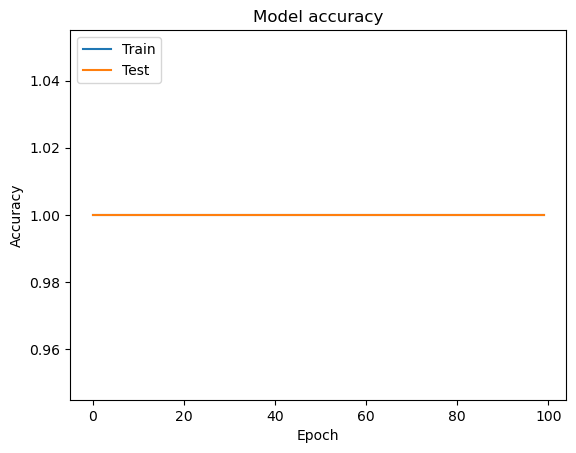

In [11]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


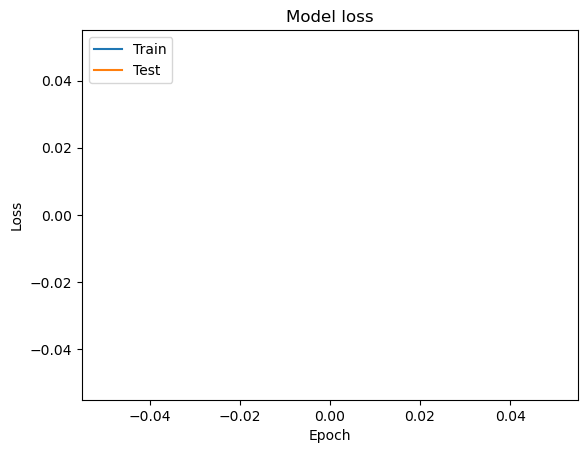

In [12]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()